In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:6' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': 1.,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=0_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
from algorithms.optimization import absolute_and_nonabsolute_minsum_LP_solver
solver = absolute_and_nonabsolute_minsum_LP_solver
converter = algorithm.converter_LP_absolute_additional_v1

params['solver'] = solver
params['converter'] = converter

In [5]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9980288591207408, 'loss': 5.089056526198455e-05, 'std': 0.0010900836105367517, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9980288591207408, 'loss': 2.8602779351932217e-05, 'std': 0.0010900836105367517, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 2.204360546055415e-05, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.8415540615294843e-05, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.5980566369620622e-05, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
loss_group=tensor([[4.5541e-03, 1.5774e-03, 9.2363e+00, 8.9315e+00]])
Elapsed time(grad):4.591
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):10.977
F

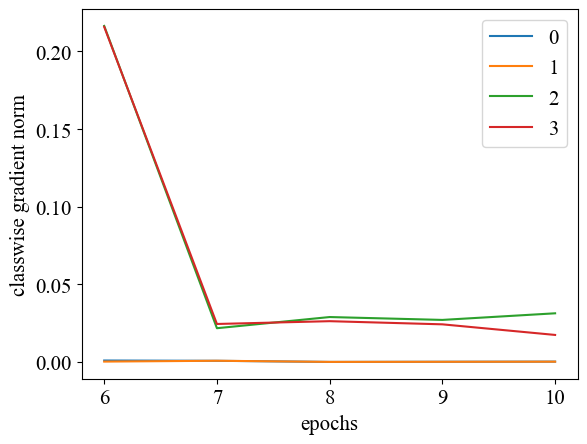

---------------------------- Task 3 -----------------------
loss_group=tensor([[1.1262e-03, 1.1096e-03, 1.5410e-01, 1.2850e-01, 9.6264e+00, 1.1361e+01]])
Elapsed time(grad):4.286
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):12.237
Fairness:[ 3.01001450e-01  5.09165351e-01  2.19390372e-01 -3.26376483e-04
 -3.45257487e-01 -6.83973207e-01]
len(updated_seq_indices)=11263
Elapsed time(etc):0.34
[11] Eval metrics for task 1 >> {'accuracy': 0.9679762653960262, 'loss': 0.0005041096385911847, 'std': 0.0047109592735772865, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8797576559981579, 'loss': 0.0016294971881954258, 'std': 0.024312111443702544, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9458424282830866, 'loss': 0.0007415170619302014, 'std': 0.027680993305508106, 'EER': -1}
loss_group=tensor([[0.0075, 0.0034, 0.0061, 0.0158, 0.1357, 0.2491]])
Elapsed time(grad):4.401
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(opt

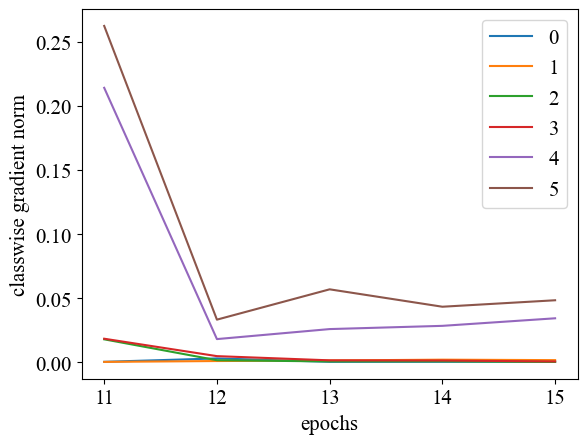

---------------------------- Task 4 -----------------------
loss_group=tensor([[8.8808e-04, 4.4789e-03, 1.9269e-03, 3.4153e-03, 2.3108e-01, 3.2595e-01,
         1.2596e+01, 1.0284e+01]])
Elapsed time(grad):4.918
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):18.114
Fairness:[ 0.25746954  0.31104305  0.09866211  0.24219984  0.12449295  0.0744854
 -0.7145746  -0.39377837]
len(updated_seq_indices)=12183
Elapsed time(etc):0.443
[16] Eval metrics for task 1 >> {'accuracy': 0.9519284365728671, 'loss': 0.000785116594170284, 'std': 0.017234559021846618, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.856554608949267, 'loss': 0.0023407044945454388, 'std': 0.0038414306546933896, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.9241446941813631, 'loss': 0.0010860331491701378, 'std': 0.02392047893472643, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 0.9438793124456755, 'loss': 0.0007236415871080435, 'std': 0.006509792612690191, 'EER': -1}
l

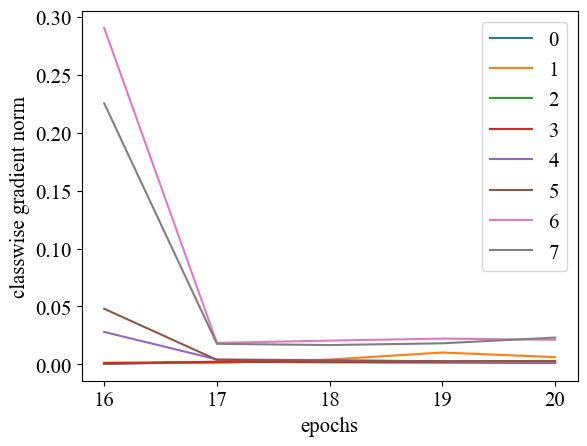

---------------------------- Task 5 -----------------------
loss_group=tensor([[4.7965e-03, 1.5110e-02, 3.6242e-03, 3.9622e-03, 5.3601e-03, 8.5091e-03,
         9.5657e-02, 1.7632e-01, 1.2118e+01, 1.1542e+01]])
Elapsed time(grad):4.718
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):20.657
Fairness:[ 0.20223238  0.20207075  0.16378718  0.16381395 -0.02005617  0.03160865
  0.19802933  0.16081885 -0.60363112 -0.49867379]
len(updated_seq_indices)=11800
Elapsed time(etc):0.715
[21] Eval metrics for task 1 >> {'accuracy': 0.9478715274656118, 'loss': 0.0008801993713593089, 'std': 0.008075609098264824, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.8370375700360734, 'loss': 0.0029784463178165748, 'std': 0.010487182439174125, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.8602193747545506, 'loss': 0.0019506786968817452, 'std': 0.021654352333025872, 'EER': -1}
[21] Eval metrics for task 4 >> {'accuracy': 0.9074961617507291, 'loss': 0.00132770469

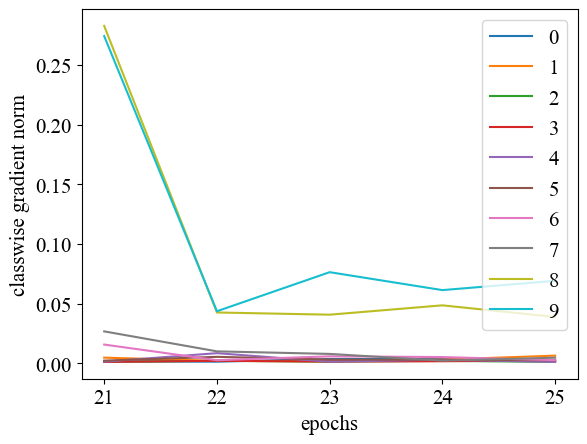

final avg-acc 0.8854827461751542
final avg-forget 0.059707132589880724


In [6]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [28]:
params['converter'] = ""

In [29]:
import pickle 

with open("dump.pickle", "wb") as f:
    pickle.dump(metric_manager_callback, f)


In [ ]:
losses, *_ = algorithm.get_loss_grad_all(params['num_tasks']) 
algorithm.true_loss[params['num_tasks']][params['epochs_per_task']] = losses

num_epochs = params['epochs_per_task']
for task in range(2, params['num_tasks']):
    algorithm.true_loss[task][num_epochs] = algorithm.true_loss[task+1][0]


KeyError: 0

In [ ]:
num_class_per_task = 2

t = algorithm.true_loss
e = algorithm.expected_loss

groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = dict()
    groupwise_expected_loss[i] = dict()

for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            groupwise_true_loss[i][(task-1)*num_epochs+epoch] = tl
            groupwise_expected_loss[i][(task-1)*num_epochs+epoch] = el
            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][ce], end='\t')
    print()


In [ ]:
groupwise_true_loss

In [ ]:
t = algorithm.true_loss
e = algorithm.expected_loss
# algorithm.true_loss[5][num_epochs] = algorithm.true_loss[5][num_epochs-1]

num_epochs = params['epochs_per_task']
for task in range(2, params['num_tasks']+1):
    print(f"{task=}")
    for epoch in range(1, num_epochs+1):
        print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
        print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
        print()
    print()


In [ ]:
import copy
task_weight = copy.deepcopy(algorithm.weight_all)

num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out


binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})




In [ ]:
num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

In [ ]:
def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out

In [ ]:
binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})

In [ ]:
binned_weight

In [ ]:
metric_manager_callback.meters['accuracy'].get_data()

In [ ]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

In [ ]:
[np.round(x, 3) for x in metric_manager_callback.meters['EER'].compute_overall()]

In [ ]:
np.mean(metric_manager_callback.meters['EER'].compute_overall())

In [ ]:
[np.round(x, 3) for x in metric_manager_callback.meters['std'].compute_overall()]

In [ ]:
np.mean(metric_manager_callback.meters['std'].compute_overall())

In [ ]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")
